## Physical Review B , 106, 035432 (2022)
Reproducing results presented in https://journals.aps.org/prb/pdf/10.1103/PhysRevB.106.035432

In [1]:
%load_ext autoreload

import kwant
import numpy as np
import matplotlib.pyplot as plt 
import kwant.continuum
import scipy.sparse.linalg as sla
import tinyarray as tiny
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib widget
mpl.rcParams.update({'font.size': 20, 'text.usetex': True,  'font.family': 'serif', 'font.serif': ['Computer Modern']})

sx = tiny.array([[0 , 1] , [1 , 0]])
sy = tiny.array([[0 , -1j] , [1j , 0]])
sz = tiny.array([[1 , 0] , [0 , -1]])


I = tiny.array([[1 , 0] , [0 , 1]])
t_plus = 0.5*(np.kron(sx , I) + 1j*np.kron(sy , I))
t_minus = t_plus.T
phs = np.kron(sy , sy)

/Users/krishnanganesh/anaconda3/lib/python3.8/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [28]:
from dataclasses import dataclass
@dataclass
class system_parameters:
    t : float # Hopping integral
    W: float # Width of normal region
    L: float # Length of normal region
    a : float # Lattice constant
    mu : float # Chemical potential
    Delta: float # SUperconducting gap.
    flux: float # Flux throught the normal region.
    phase: float  # Josephson phase difference. 

params = system_parameters(t =1 , W = 20 , L = 5 , a = 0.5, Delta = 2 , mu = 0.5, flux= 0 , phase = (0.2)*(2*np.pi))

# In my units e = h = 1. So Phi_0 , the elementary flux quantum (h/e) is 1 and the superconducting flux quantum Phi_S (h/2e) is 1/2. 
# Flux is given in units of the elementary flux quantum.

# Function for computing normal S-matrix. 
def compute_normal_s_matrix(params):
    B = params.flux/((params.W)*(params.L ))
    peierlphase = B*params.a*2*np.pi
    syst = kwant.Builder()
    lat = kwant.lattice.square(a = params.a , norbs = 1)
    for i in range(int(params.W / params.a)):
        for j in range(int(params.L / params.a)):
            syst[lat(i , j)] = 4*params.t/(params.a**2) - params.mu
            if i > 0:
                syst[lat(i , j) , lat(i-1 , j)] = -params.t/(params.a**2)
            if j > 0:
                syst[lat(i , j) , lat(i , j-1)] = -params.t*np.exp(1j*(i*params.a)*peierlphase)/(params.a**2)
    
    # Construct normal leads, with no magnetic field to account for screening.
    lead = kwant.Builder(kwant.TranslationalSymmetry((0 , -params.a)))
    for i in range(int(params.W / params.a)):
        lead[lat(i , 0)] = 4*params.t - params.mu
        if i > 0:
            lead[lat(i , 0) , lat(i-1 , 0)] = -params.t
        lead[lat(i , 1) , lat(i , 0)] = -params.t
    
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    syst = syst.finalized()
    # Compute S-matrix of the normal region between leads. In the short junction regime , we can calcualte it at E = 0.
    s_matrix = kwant.smatrix(syst , 0)
    wf = kwant.wave_function(syst , energy = 0)
    return s_matrix , wf , syst

In [29]:
s_matrix_test , wf , syst = compute_normal_s_matrix(params)
lead_info = s_matrix_test.lead_info
num_propagating = s_matrix_test.num_propagating(1)
print(num_propagating)
len(lead_info[0].momenta)

9


18

In [30]:
(s_matrix_test.data).shape

(18, 18)

In [31]:
# Andreev reflection matrix:
def andreev(smatrix , params):
    # We need to know how many modes are in each lead:
    N = smatrix.num_propagating(0)
    M = smatrix.num_propagating(1)

    r_A00 = 1j*np.identity(N)
    r_A11 = 1j*np.exp(-1j*params.phase)*np.identity(M)
    r_A01 = np.zeros(shape = (N , M))
    r_A10 = np.zeros(shape = (M , N))
    r_A = np.block([[r_A00 , r_A01],[r_A10 , r_A11]])
    r_A_deriv = np.block([[np.zeros(shape = (N , N)) , r_A01],[r_A10 , -1j*r_A11]])
    return  r_A , r_A_deriv

# Compute Andreev bound states:
def compute_ABS(smatrix , params):
    r_A = andreev(smatrix , params)[0]
    s = smatrix.data
    #  Calculate A matrix:
    A = (-s.T @ r_A + r_A @ s)/2
    
    # Constructing matrix to diagonalise for energies:
    zeroes = np.zeros(shape = A.shape)
    matrix = np.block([[zeroes , -1j*np.conjugate(A.T)],[1j*A , zeroes]])
    evals , evecs = np.linalg.eigh(params.Delta*matrix)
    return evals , evecs

In [32]:
evals , evecs = compute_ABS(s_matrix_test , params)
print(wf(0).shape)
print(evecs.shape)

print(np.max(evecs.imag))

(9, 400)
(36, 36)
0.7001881546662058


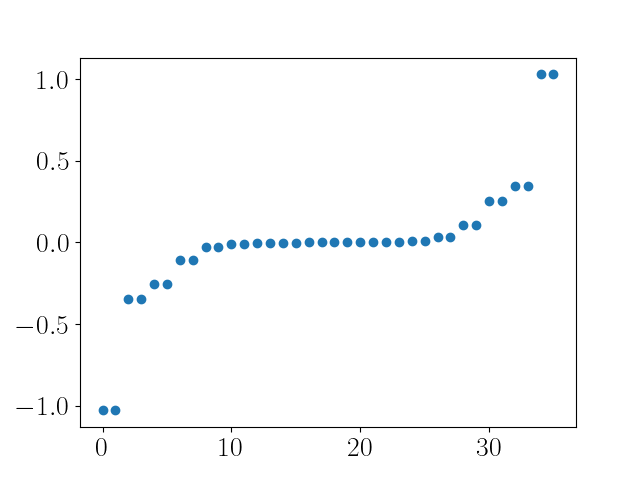

In [33]:
plt.figure()
plt.scatter(np.arange(len(evals)) , evals)

In [34]:
# eigenvectors for positive energies:
evecs_positive = evecs[: , evals > 0]
print(evecs_positive.shape)

(36, 18)


In [35]:
# Compute critical currents:
def compute_I_c(flux_value , params , no_phases = 101):
    # Values for superconducting phase
    phases = np.linspace(0 , 2*np.pi , no_phases)
    params.flux = flux_value
    pos_evals = []
    for phase in phases:
        params.phase = phase
        smatrix = compute_normal_s_matrix(params)[0]
        evals , evecs = compute_ABS(smatrix , params)
        # Extract positive evals:
        pos_evals.append(evals[evals > 0])
    pos_evals = np.stack(pos_evals , axis = 1)
    # Sum up all the positive eigenenergies for each pahse value:
    summed = np.sum(pos_evals , axis = 0)
    # Current is gradient of all of the positive eigeneneries:
    current = np.gradient(summed , phases)
    I_c = np.max(current)
    return I_c , [phases , current]

In [55]:
def calculate_supercurrent_distribution(flux_value , phase , params):
    # Calculate supercurrent distribution in junction from ABS amplitudes:
    params.flux = flux_value
    params.phase = phase
    smatrix , wf , syst = compute_normal_s_matrix(params)
    evals , evecs = compute_ABS(smatrix , params)

    # Extract eigenvectors that correspond to positive energy ABS:
    evecs_pos = evecs[: , evals> 0]
    electron_vectors = evecs_pos[ 0 : int(evecs_pos.shape[0]/2) , :]
    hole_vectors = evecs_pos[ int(evecs_pos.shape[0]/2) :   , :]

    # Zero energy scattering wavefunctions:
    psi_wf = np.vstack((wf(0) , wf(1)))

    # Electron amplitudes:
    A_e = electron_vectors @ psi_wf
    # Hole_amplitudes:
    A_h = hole_vectors @ np.conj(psi_wf)

    # Probablitity current operator:
    J = kwant.operator.Current(syst , 1)

    # Charge amplitude:
    total_current = 0
    # COmputing difference between electron and hole currents for each positive energy eigenstate:
    for i in range(A_e.shape[0]):
        J_e = -J(A_e[i , :])
        J_h = J(A_h[i , :])

        total_current += J_e
    
    kwant.plotter.current(syst , total_current);
    return total_current , A_e , A_h , psi_wf

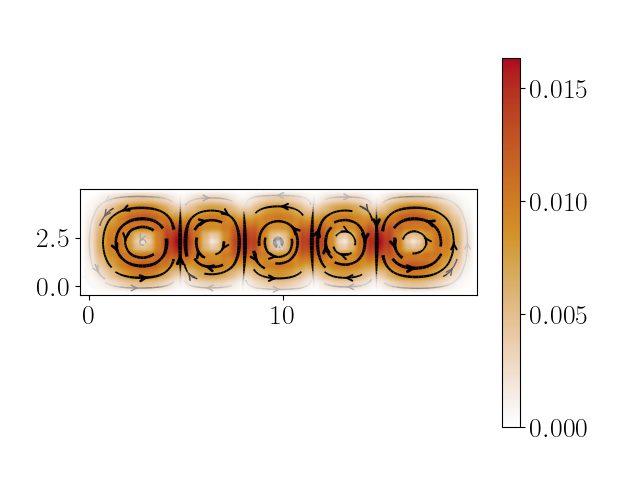

In [59]:
tc , a_e , a_h , psi_wf = calculate_supercurrent_distribution(0.2 , 0.0 , params)

In [100]:
I_c_test , [phases_test , currents_test] = compute_I_c(0.559 , params , no_phases = 201)

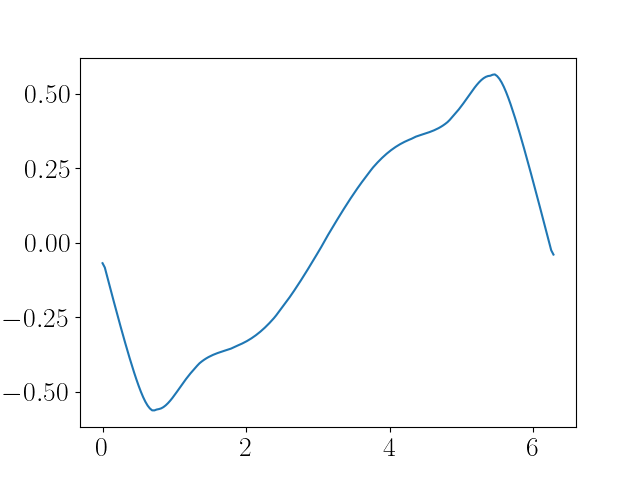

In [102]:
plt.figure()
plt.plot(phases_test , currents_test)

In [106]:
np.linspace(0 , 2 , 81)

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
       0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
       0.9  , 0.925, 0.95 , 0.975, 1.   , 1.025, 1.05 , 1.075, 1.1  ,
       1.125, 1.15 , 1.175, 1.2  , 1.225, 1.25 , 1.275, 1.3  , 1.325,
       1.35 , 1.375, 1.4  , 1.425, 1.45 , 1.475, 1.5  , 1.525, 1.55 ,
       1.575, 1.6  , 1.625, 1.65 , 1.675, 1.7  , 1.725, 1.75 , 1.775,
       1.8  , 1.825, 1.85 , 1.875, 1.9  , 1.925, 1.95 , 1.975, 2.   ])

In [107]:
from tqdm import tqdm
fluxes = np.linspace(0 , 2 , 81)
I_c_values = np.zeros(len(fluxes))
CPRS = []
for i in tqdm(range(len(fluxes))):
    I_c_values[i] , current_phase_relation = compute_I_c(fluxes[i] , params , no_phases = 201)
    CPRS.append(current_phase_relation)

100%|██████████| 81/81 [15:25<00:00, 11.43s/it]


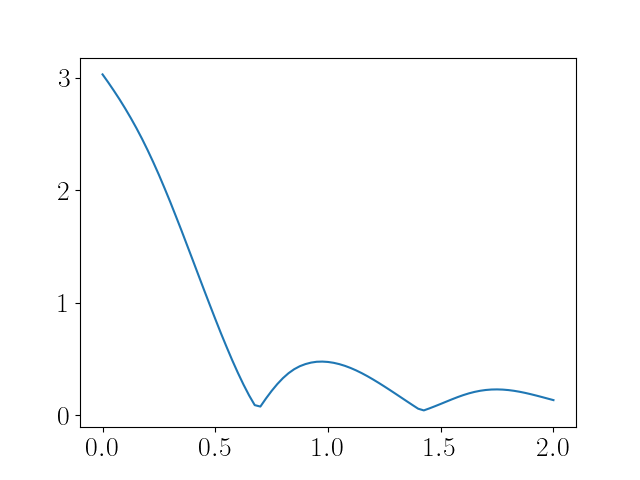

In [109]:
plt.figure()
plt.plot(fluxes , I_c_values)

In [ ]:
test_list= [np.array([1 , 0]) , np.array([2 , 3])]
stacked = np.stack(test_list  , axis= 1)
stacked


In [27]:
blah = np.array([[1 , 0],[2 , 3] , [4 , 5], [7 , 8]])
print(blah[0 : int(blah.shape[0]/ 2) , :])
print(blah[int(blah.shape[0] / 2) :  , :])
np.vstack((np.array([1 , 0]) , np.array([2 , 3])))

[[1 0]
 [2 3]]
[[4 5]
 [7 8]]


array([[1, 0],
       [2, 3]])